In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from torch.autograd import Variable

In [37]:
latent_shape = 100
input_shape = (3,32,32)
batch_size = 32
lr = 0.0002
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fixed_noise = torch.randn(batch_size, latent_shape, 1, 1, device=device)
Tensor = torch.cuda.FloatTensor if 'cuda' in device else torch.FloatTensor

In [27]:
class Generator(nn.Module):
    def __init__(self, latent_shape):
        super(Generator, self).__init__()
        # input shape of (batch_size, latent_space, 1, 1)
        # output shape : 512 x 4 x 4
        self.upsample1 = nn.ConvTranspose2d(latent_shape, 256, 4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(256)
        # input shape : 512 x 4 x 4
        # output shape : 256 x 8 x 8
        self.upsample2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # input shape : 256 x 8 x 8
        # output shape : 128 x 16 x 16
        self.upsample3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # input shape : 128 x 16 x 16
        # output shape : 3 x 32 x 32
        self.upsample4 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.bn1(self.upsample1(x)))
        x = self.relu(self.bn2(self.upsample2(x)))
        x = self.relu(self.bn3(self.upsample3(x)))
        x = self.tanh(self.upsample4(x))
        return x

In [28]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        # shape : 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # shape : 64 x 16 x 16
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # shape : 128 x 8 x 8
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # shape : 256 x 4 x 4
        self.conv4 = nn.Conv2d(256, 1, 4, stride=2, padding=0)
        # shape : 512 x 1 x 1
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.sigmoid(self.conv4(x))
        return x

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, 
                                         drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [30]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [31]:
device

'cuda'

In [32]:
modelG = Generator(latent_shape).to(device)
modelG.apply(init_weights)

modelD = Discriminator(input_shape).to(device)
modelD.apply(init_weights)

# optimizer and criterion
criterion = nn.BCELoss().to(device)
optimizerG = torch.optim.Adam(modelG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(modelD.parameters(), lr=lr, betas=(0.5, 0.999))

In [33]:
def generate_fake_batch(weights=None):
  if weights:
    modelG.load_state_dict(weights)
  latent_input = torch.randn(batch_size, latent_shape, 1, 1)
  generator_out = modelG(latent_input.to(device))
  return generator_out

In [38]:
img_list = []
def train(epochs, printfreq=1000):
  modelD.train()
  modelG.train()
  
  real_label = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
  fake_label = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)
  
  for epoch in range(epochs):
    for i, batch in enumerate(trainloader):
      # get data
      real_images = batch[0].to(device)
      gen_images = generate_fake_batch()
      # train discriminator
      modelD.zero_grad()
      real_loss = criterion(modelD(real_images).view(-1), real_label)
      fake_loss = criterion(modelD(gen_images.detach()).view(-1), fake_label)
      # calculate avg total loss
      lossD = (real_loss + fake_loss)/2
      lossD.backward()
      optimizerD.step()

      # train generator
      modelG.zero_grad()
      # Loss measures G's ability to fool D.
      output = modelD(gen_images).view(-1)
      lossG = criterion(output, real_label)
      # Calculate gradients for G
      lossG.backward()
      # Update G
      optimizerG.step()


      if i % printfreq == 0:
        print(f"Epoch : {epoch}, Iteration : {i}, lossD: {lossD.item()}, "
              f"lossG: {lossG.item()}")

    if epoch % 10 == 0:
      checkpoint = {'generator' : modelG.state_dict(),
                    'generator_optim' : optimizerG.state_dict(),
                    'discriminator' : modelD.state_dict(),
                    'discriminator_optim' : optimizerD.state_dict()}
      torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pth")
    if (epoch % 5 == 0):
        with torch.no_grad():
            fake = modelG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

In [39]:
train(100)

Epoch : 0, Iteration : 0, lossD: 0.001230419147759676, lossG: 8.506967544555664
Epoch : 0, Iteration : 1000, lossD: 0.07573795318603516, lossG: 6.764952659606934
Epoch : 1, Iteration : 0, lossD: 0.003043749835342169, lossG: 10.46875
Epoch : 1, Iteration : 1000, lossD: 0.009553693234920502, lossG: 7.633134841918945
Epoch : 2, Iteration : 0, lossD: 0.013082891702651978, lossG: 11.051488876342773
Epoch : 2, Iteration : 1000, lossD: 0.0013433897402137518, lossG: 8.991741180419922
Epoch : 3, Iteration : 0, lossD: 0.003147076116874814, lossG: 9.365724563598633
Epoch : 3, Iteration : 1000, lossD: 0.0288713276386261, lossG: 8.029136657714844
Epoch : 4, Iteration : 0, lossD: 0.005096801556646824, lossG: 9.169189453125
Epoch : 4, Iteration : 1000, lossD: 0.002126838080585003, lossG: 9.48409366607666
Epoch : 5, Iteration : 0, lossD: 0.0037183589302003384, lossG: 10.527033805847168
Epoch : 5, Iteration : 1000, lossD: 0.9425801634788513, lossG: 3.3620331287384033
Epoch : 6, Iteration : 0, lossD: 0.

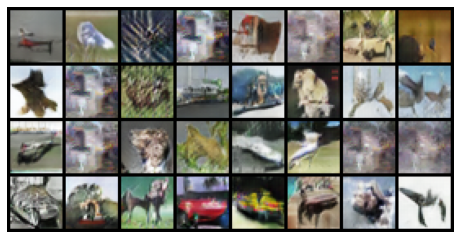

In [40]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())